In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import *

%matplotlib inline

## Load data

In [2]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

## Tests
### Initialization, and error cases

In [16]:
# These casee should run smothly 
a = Author(0.52,1.,0.,.8,'w')
# case insensitivity
a = Author(0.05,.1,.57,.7,'W')
a = Author(0.5,.6,.7,.8,'m')
# default gender should be W, and others should count up from .5
a = Author(0.5,.6,.7,.8)
print(a.gender)
print(a.network_bias)
print(a.walk_bias)
print(a.meet_bias)
print(a.learn_bias)

W
0.5
0.6
0.7
0.8


In [17]:
# Type checking, this should throw error
a = Author(0.5,.5,.5,.5,1)

Exception: Gender should be a string, W or M

In [18]:
# Type checking, this should throw error
a = Author(1,.5,.5,.5,'m')

Exception: Network bias should be a float

In [19]:
# Type checking, this should throw error
a = Author(.5,'.5',.5,.5,'m')

Exception: Walk bias should be a float

In [20]:
# value errors for gender. this should throw an error
a = Author(.5,.5,.5,.5,'f')

Exception: Gender should be W or M

In [21]:
# value errors for bias params. this should throw an error
a = Author(.5,.5,.5,1.2,'w')

Exception: Beta should be between 0 and 1

In [22]:
# value errors for bias params. this should throw an error
a = Author(1.,.0,-.5,.2,'w')

Exception: Meeting bias should be between 0 and 1

### Network initialization function

In [23]:
# This case should run smoothly, with the proper number of nodes
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100,  5)
print(a.network.summary())

NameError: name 'np' is not defined

In [24]:
# error case - network too big
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 500000, 5)

Exception: You have requested a network bigger than the largest connected component

In [85]:
# error case - incorrect levy coeff
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5, c=5)

Exception: Your levy coefficient should be between 1 and 3

In [86]:
# error case - diameter too big
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, d=0.5)

Exception: Your diameter should be greater than 0

In [87]:
# qualitative gender bias check, this should be mostly orange
a = Author(1.0,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5)
print(a.network.summary())

IGRAPH UN-- 100 609 -- 
+ attr: gender (v), name (v)


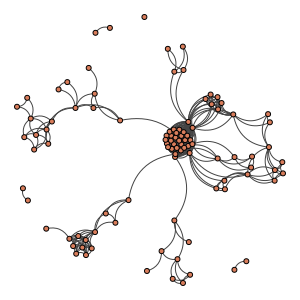

In [88]:
visual_style = {}

# Define colors used for gender visualization (purple is men)
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'man' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (300,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)

In [91]:
# qualitative gender bias check, this should be mostly purple
a = Author(0.0,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5)
print(a.network.summary())

IGRAPH UN-- 100 259 -- 
+ attr: gender (v), name (v)


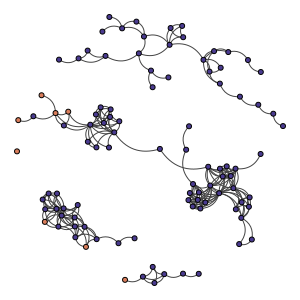

In [92]:
visual_style = {}

# Define colors used for gender visualization
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'man' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (300,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)

In [93]:
# qualitative gender bias check, this should be mixed
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5)
print(a.network.summary())

IGRAPH UN-- 100 192 -- 
+ attr: gender (v), name (v)


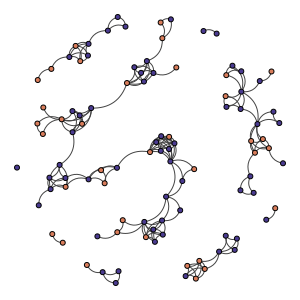

In [94]:
visual_style = {}

# Define colors used for gender visualization
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'man' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (300,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)

#### Parameter sweeps

In [18]:
# gender proportion based on bias parameter
nSim = 50
net_biases = np.linspace(0.,1.,50)
n = 100

def test_gender_prop(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a = Author(b,.5,.5,.5,'w')
    for j in range(nSim):
        a.init_network(g, node_2_gender, n, 5)
        props[j,] = len(a.network.vs.select(gender='woman'))/n
    return props


genderProps = Parallel(n_jobs=4)(
    delayed(test_gender_prop)(b,nSim,g,node_2_gender,n)
    for b in tqdm(net_biases)
) 
    

100%|██████████| 50/50 [16:48<00:00, 20.18s/it]


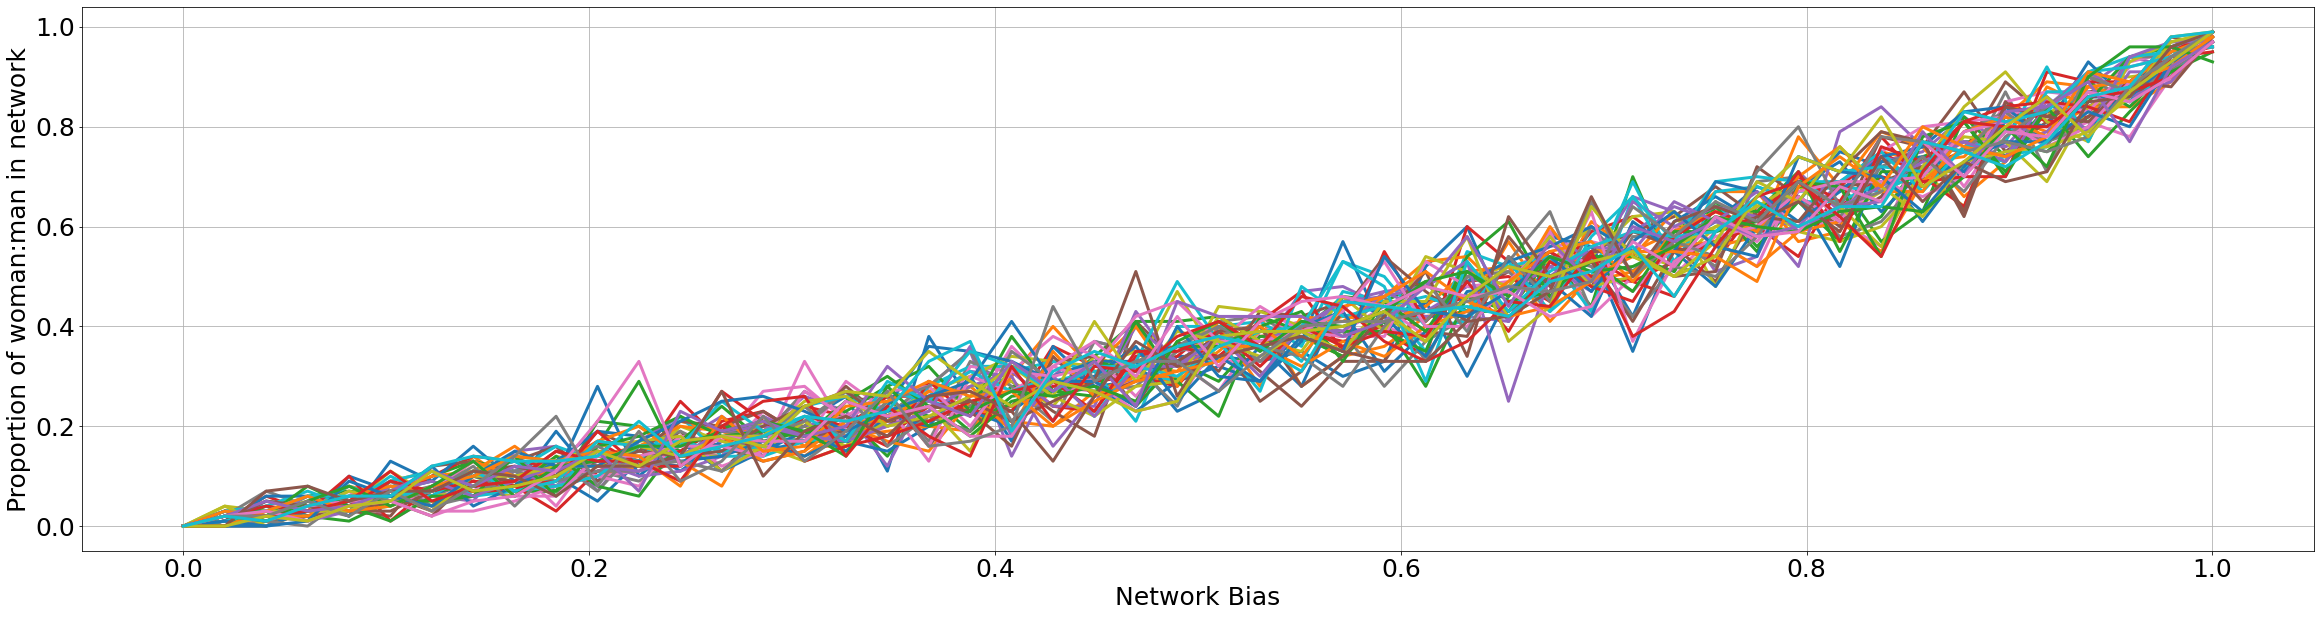

<Figure size 432x288 with 0 Axes>

In [19]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(net_biases, np.reshape(genderProps, (nSim, len(net_biases))), linewidth=3.0)
plt.ylabel('Proportion of woman:man in network')
plt.xlabel('Network Bias')

plt.grid(True)
plt.show()
plt.draw()

In [22]:
# variability in edge numbers across instantitions
nSim = 50
net_biases = [0., .25, .5, .75, 1.]
n = 100

def test_edges(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a = Author(b,.5,.5,.5,'w')
    for j in range(nSim):
        a.init_network(g, node_2_gender, n, 7)
        props[j,] = len(a.network.es())
    return props

edge_nums = Parallel(n_jobs=4)(
    delayed(test_edges)(b,nSim,g,node_2_gender,n)
    for b in tqdm(net_biases)
) 



100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


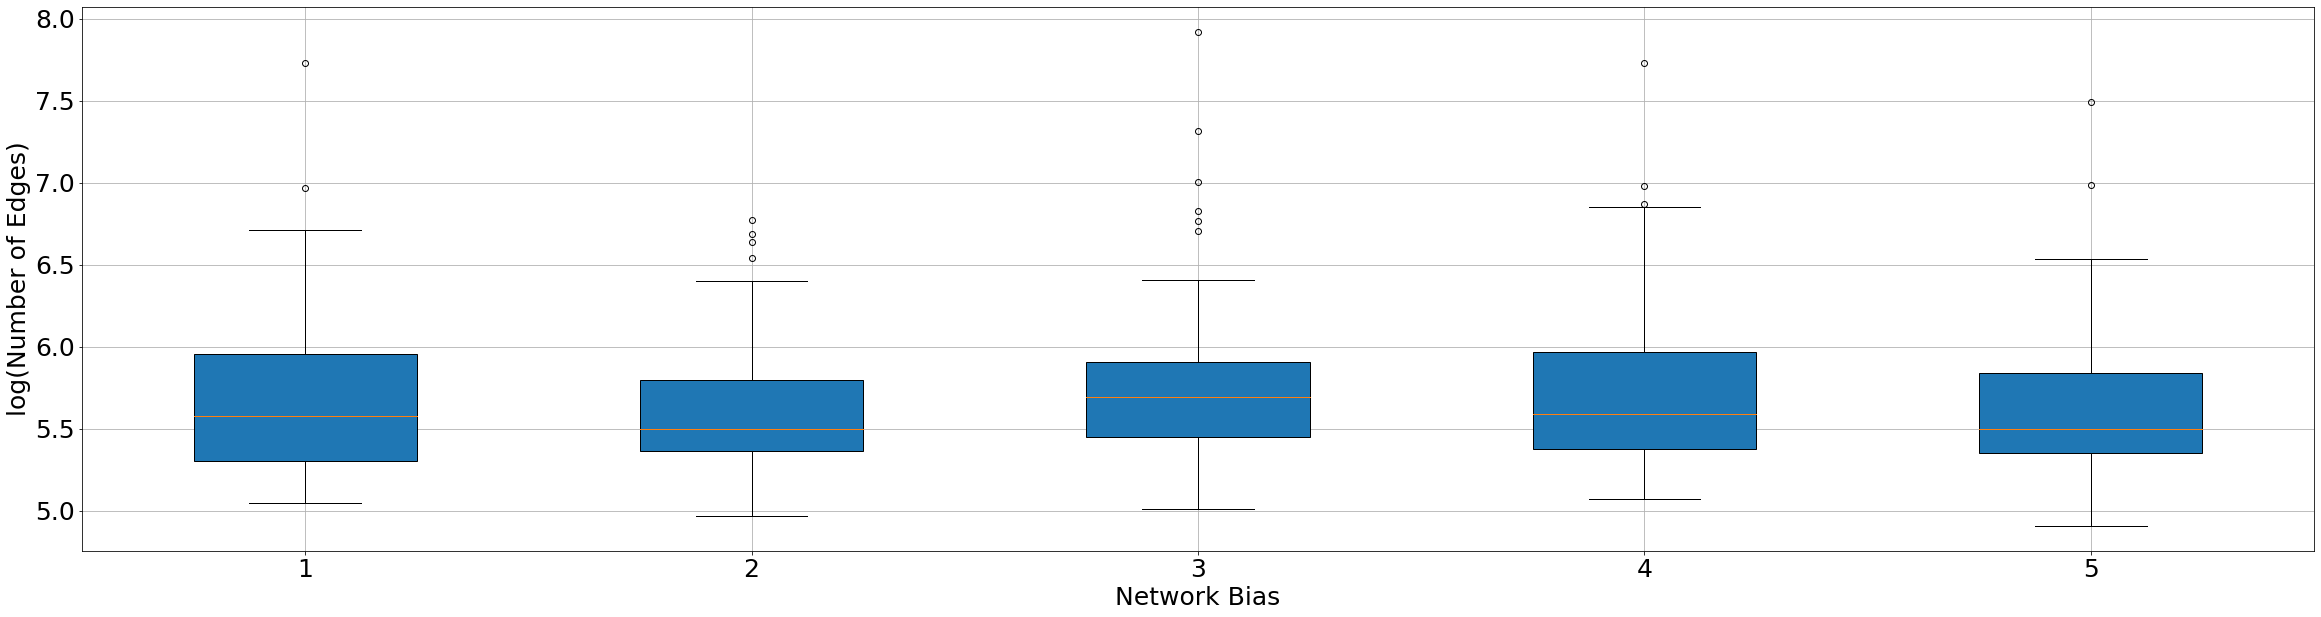

<Figure size 432x288 with 0 Axes>

In [25]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.boxplot(np.reshape(np.log(edge_nums), (nSim, len(net_biases))),patch_artist=True)
plt.ylabel('log(Number of Edges)')
plt.xlabel('Network Bias')

plt.grid(True)
plt.show()
plt.draw()

In [26]:
# number of connected components for different instances
nSim = 50
net_biases = [0., .25, .5, .75, 1.]
n = 100

def test_edges(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a = Author(b,.5,.5,.5,'w')
    for j in range(nSim):
        a.init_network(g, node_2_gender, n, 7)
        props[j,] = len(a.network.components())
    return props

comp_nums = Parallel(n_jobs=4)(
    delayed(test_edges)(b,nSim,g,node_2_gender,n)
    for b in tqdm(net_biases)
) 



  0%|          | 0/5 [11:50<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


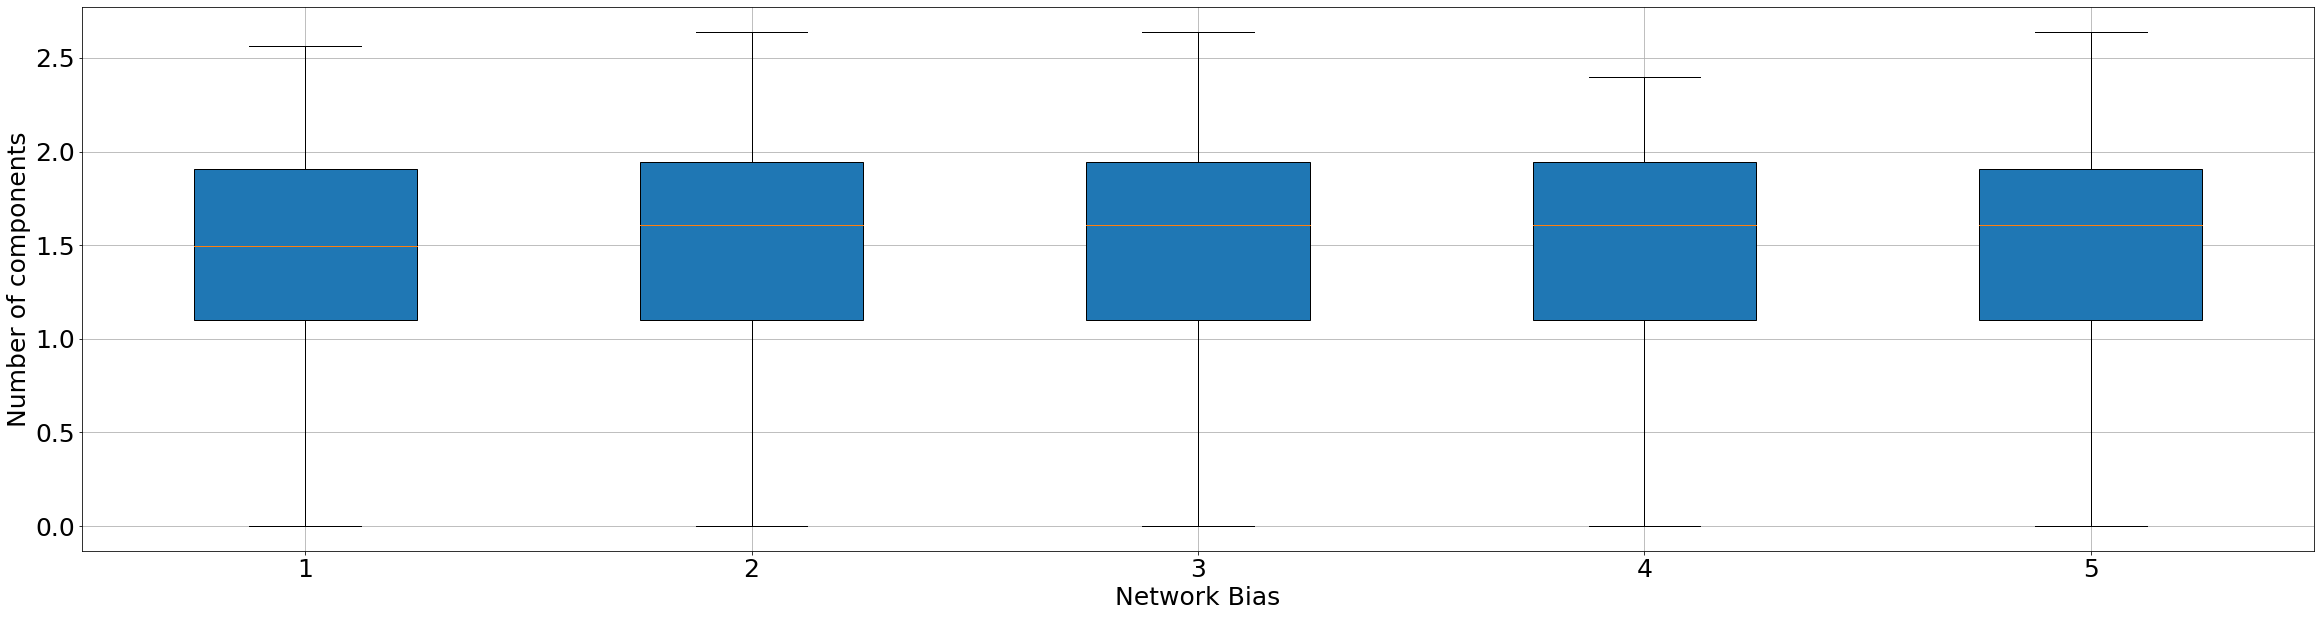

<Figure size 432x288 with 0 Axes>

In [27]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.boxplot(np.reshape(np.log(comp_nums), (nSim, len(net_biases))),patch_artist=True)
plt.ylabel('Number of components')
plt.xlabel('Network Bias')

plt.grid(True)
plt.show()
plt.draw()

In [49]:
# variation in connected components for levy coeff 
nSim = 20
net_biases = [0., .25, .5, .75, 1.]
levy_coeff = np.linspace(1,3,50)
n = 100

def test_lc(b,lc,g,node_2_gender,n,nSim):
    props = np.zeros((len(lc),nSim))
    a = Author(b,.5,.5,.5,'w')
    for j,c in enumerate(lc):
        for k in range(nSim):
            a.init_network(g, node_2_gender, n,d=20, c=c)
            props[j,k] = len(a.network.components())
        print(np.mean(props,axis=1))
    return np.mean(props,axis=1)

lc_nums = Parallel(n_jobs=4)(
    delayed(test_lc)(b,levy_coeff,g,node_2_gender,n,nSim)
    for b in tqdm(net_biases)
) 


100%|██████████| 5/5 [00:00<00:00, 2445.09it/s]


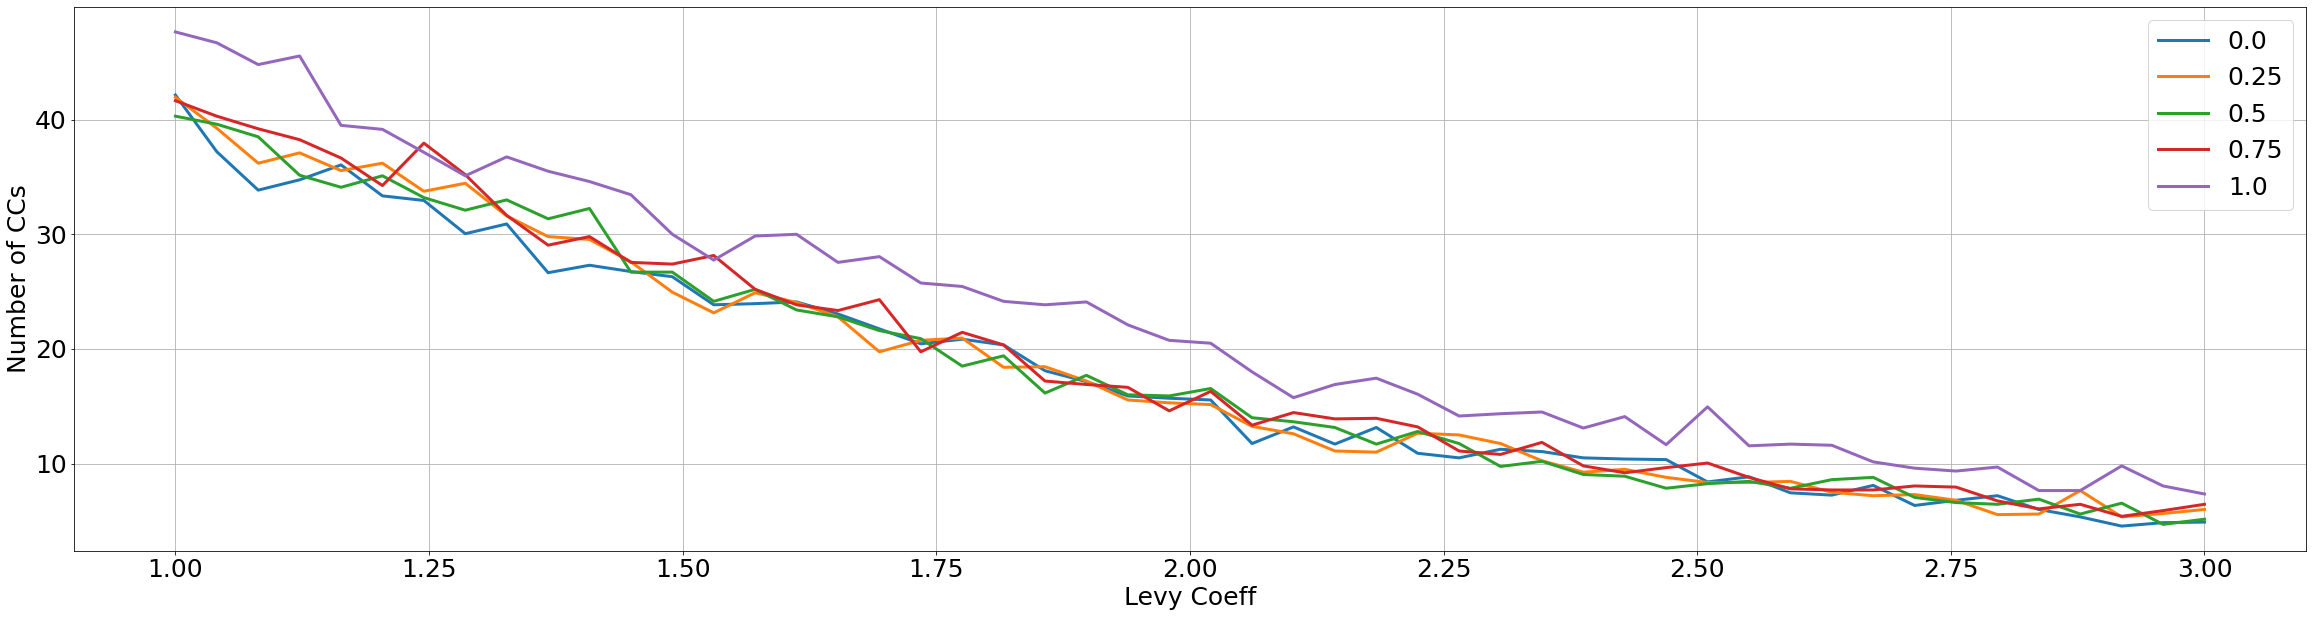

<Figure size 432x288 with 0 Axes>

In [55]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(levy_coeff, np.reshape(lc_nums, (len(net_biases), len(levy_coeff))).T, linewidth=3.0)
plt.ylabel('Number of CCs')
plt.xlabel('Levy Coeff')
plt.legend(net_biases)

plt.grid(True)
plt.show()
plt.draw()

In [61]:
# variation in connected components for diam
nSim = 20
net_biases = [0., .25, .5, .75, .99]
ds = range(1,50)
n = 100

def test_diam(b,ds,g,node_2_gender,n,nSim):
    props = np.zeros((len(ds),nSim))
    a = Author(b,.5,.5,.5,'w')
    for j,diam in enumerate(ds):
        for k in range(nSim):
            a.init_network(g, node_2_gender, n,d=diam)
            props[j,k] = len(a.network.components())
    return np.mean(props,axis=1)

d_nums = Parallel(n_jobs=1)(
    delayed(test_diam)(b,ds,g,node_2_gender,n,nSim)
    for b in tqdm(net_biases)
) 



100%|██████████| 5/5 [1:52:15<00:00, 1347.09s/it]


 80%|████████  | 4/5 [73:44:48<18:26:12, 66372.10s/it]


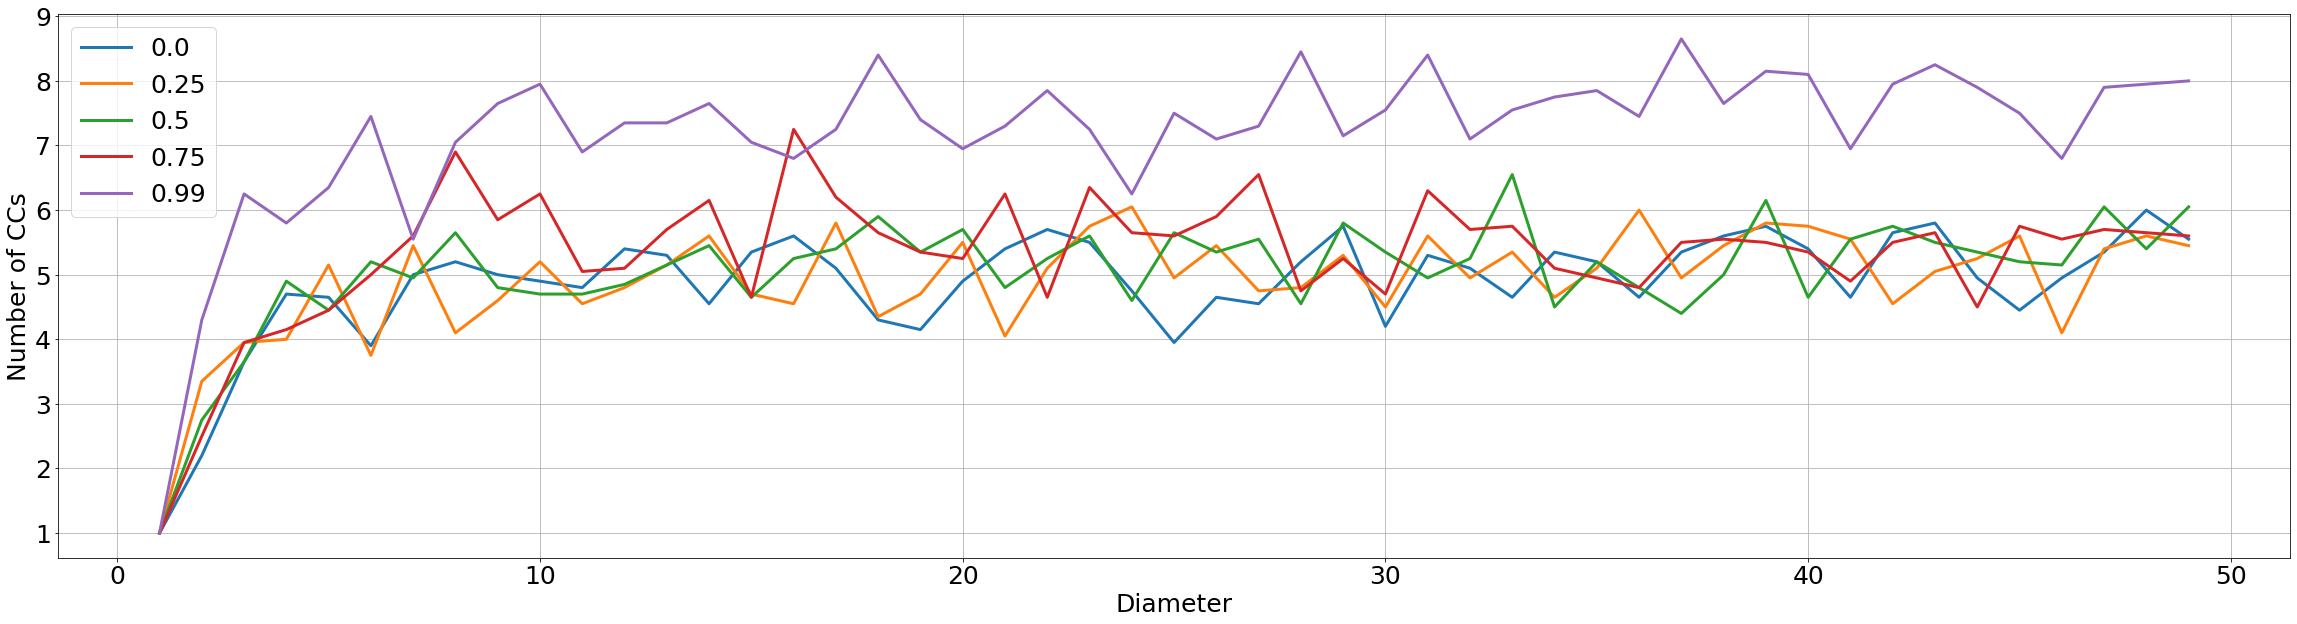

<Figure size 432x288 with 0 Axes>

In [66]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(ds, np.reshape(d_nums, (len(net_biases), len(ds))).T, linewidth=3.0)
plt.ylabel('Number of CCs')
plt.xlabel('Diameter')
plt.legend(net_biases)

plt.grid(True)
plt.show()
plt.draw()

In [78]:
# different network sizes
# gender proportion based on bias parameter
nSim = 50
net_biases = [0., .25, .5, .75, .99]
n = [100, 200, 300, 400, 500]

def test_gender_prop(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,len(n)))
    a = Author(b,.5,.5,.5,'w')
    for j in range(nSim):
        for i,k in enumerate(n):
            a.init_network(g, node_2_gender, k, 5)
            props[j,i] = len(a.network.vs.select(gender='woman'))/k
    return np.mean(props,axis=0)


genderProps = Parallel(n_jobs=1)(
    delayed(test_gender_prop)(b,nSim,g,node_2_gender,n)
    for b in tqdm(net_biases)
) 
   

100%|██████████| 5/5 [35:32<00:00, 426.56s/it]


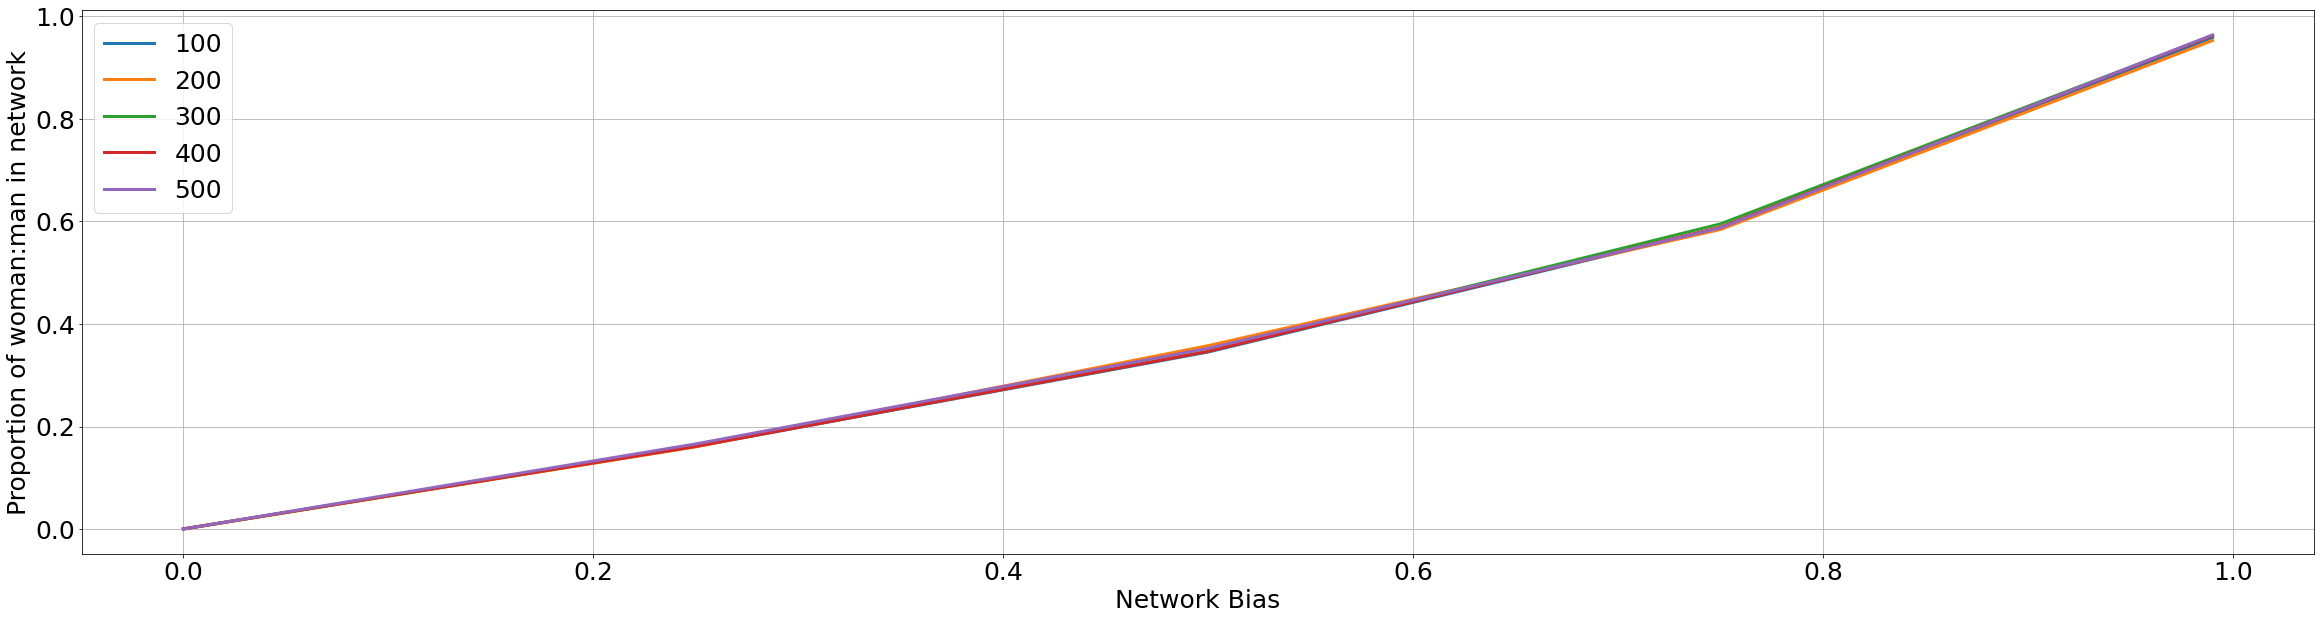

<Figure size 432x288 with 0 Axes>

In [79]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(net_biases, np.reshape(genderProps, (len(n), len(net_biases))), linewidth=3.0)
plt.ylabel('Proportion of woman:man in network')
plt.xlabel('Network Bias')
plt.legend(n)

plt.grid(True)
plt.show()
plt.draw()

In [101]:
# assortativity
# gender proportion based on bias parameter
nSim = 20
net_biases = np.linspace(0.,1.,50)
n = 100

def test_gender_prop(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a = Author(b,.5,.5,.5,'w')
    for j in range(nSim):
        a.init_network(g, node_2_gender, n)
        idx = [1 if v['gender'] == 'woman' else 0 for v in a.network.vs()]
        props[j,] = a.network.assortativity(idx,directed=False)
    return props


genderProps = Parallel(n_jobs=1)(
    delayed(test_gender_prop)(b,nSim,g,node_2_gender,n)
    for b in tqdm(net_biases)
) 


100%|██████████| 50/50 [20:50<00:00, 25.01s/it]


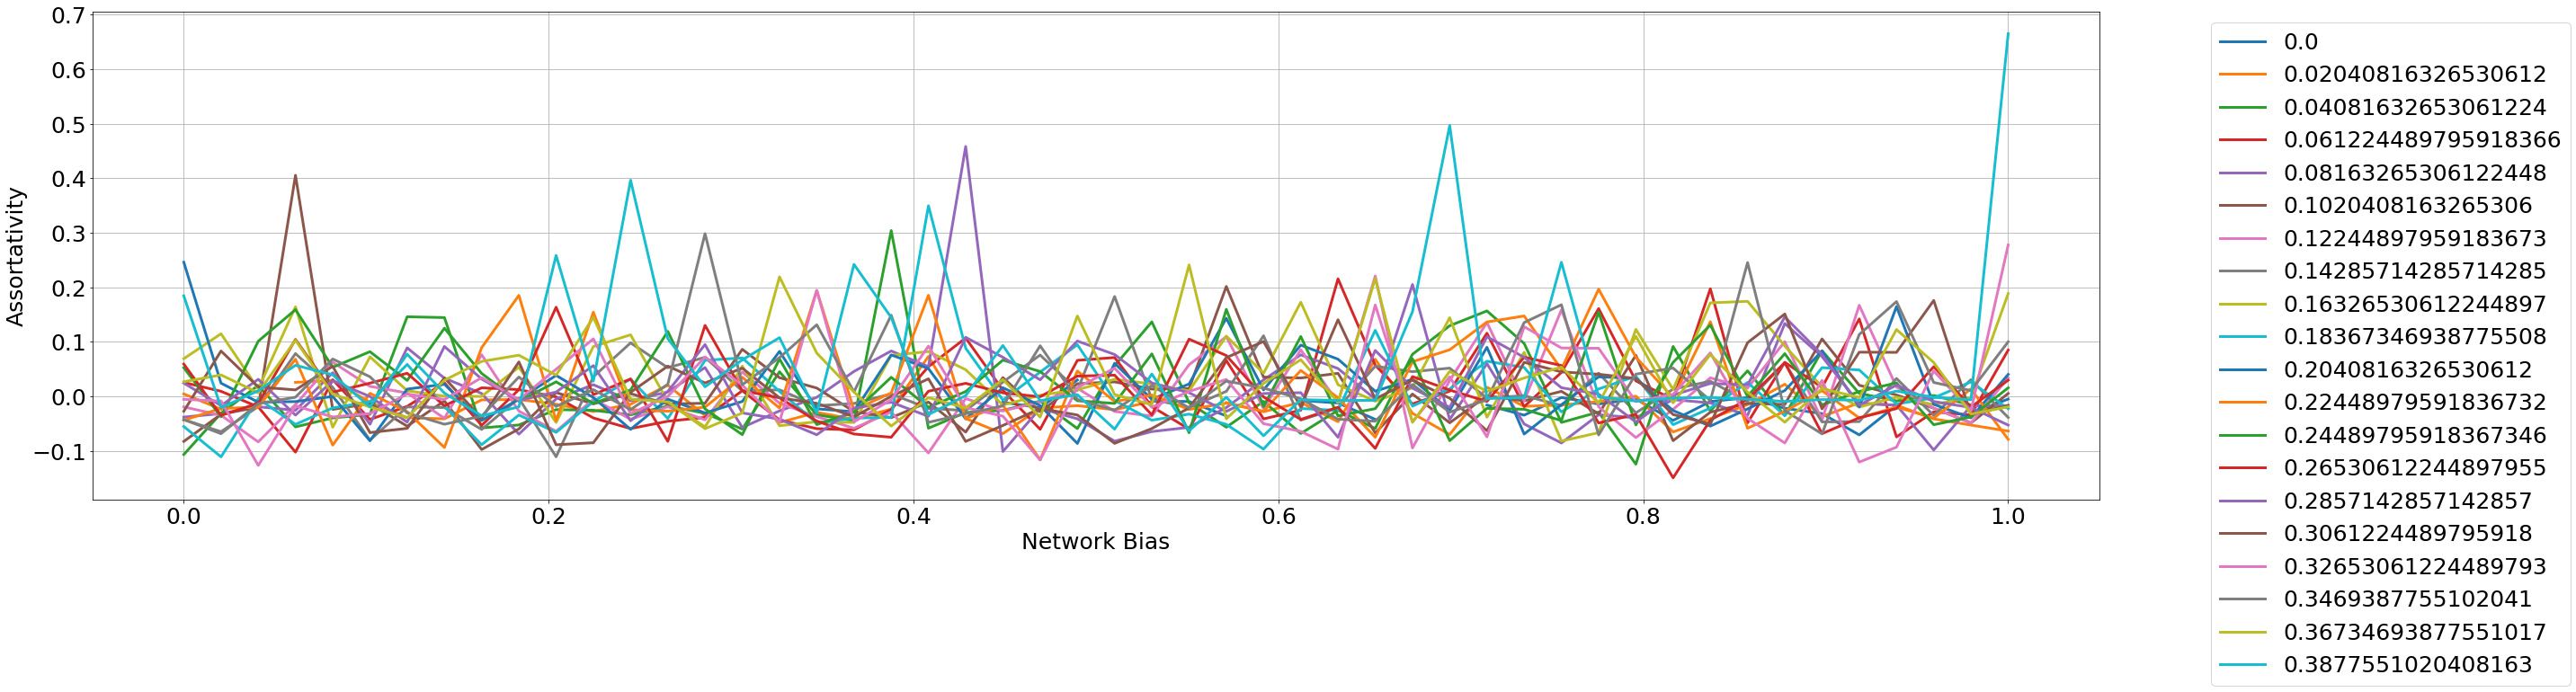

<Figure size 432x288 with 0 Axes>

In [110]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(net_biases, np.reshape(genderProps, (nSim, len(net_biases))).T, linewidth=3.0)
plt.ylabel('Assortativity')
plt.xlabel('Network Bias')

plt.legend(net_biases,bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()
plt.draw()

### Generate Citations function

In [182]:
# these should run smoothly
a = Author(0.5,0.5,0.5,0.5)
a.init_network(g,node_2_gender,50)
a.get_cites(1)
a.get_cites(500)
bib = a.get_cites(10)
print(bib)

{0: {'id': 9, 'gender': 'man', 'oid': 60536}, 1: {'id': 5, 'gender': 'woman', 'oid': 60526}, 2: {'id': 6, 'gender': 'man', 'oid': 60547}, 3: {'id': 10, 'gender': 'man', 'oid': 60531}, 4: {'id': 6, 'gender': 'man', 'oid': 60547}, 5: {'id': 10, 'gender': 'man', 'oid': 60531}, 6: {'id': 8, 'gender': 'man', 'oid': 60545}, 7: {'id': 10, 'gender': 'man', 'oid': 60531}, 8: {'id': 4, 'gender': 'woman', 'oid': 60528}}


In [183]:
# should throw error
a.get_cites(1.2)

Exception: N should be an integer

In [184]:
# should throw error
a.get_cites(-4)

Exception: N should be an integer greter than 0

#### Parameter sweeps
Some, in combinaton with network initiaization

In [43]:
# citation bias with different walk biases
nSim = 20
walk_biases = np.linspace(0., 1.,50)
nn = 100
nb = 70

def test_cites(b,g,node_2_gender,n,nb,nSim):
    props = np.zeros((nSim,1))
    a = Author(.5,b,.5,.5,'w')
    a.init_network(g, node_2_gender, n)
    for k in range(nSim):
        bib = a.get_cites(nb)
        props[k] = sum([val['gender'] == 'woman' for val in bib.values()])/nb
    return np.mean(props,axis=0)

cites = Parallel(n_jobs=1)(
    delayed(test_cites)(b,g,node_2_gender,nn,nb,nSim)
    for b in tqdm(walk_biases) 
)

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


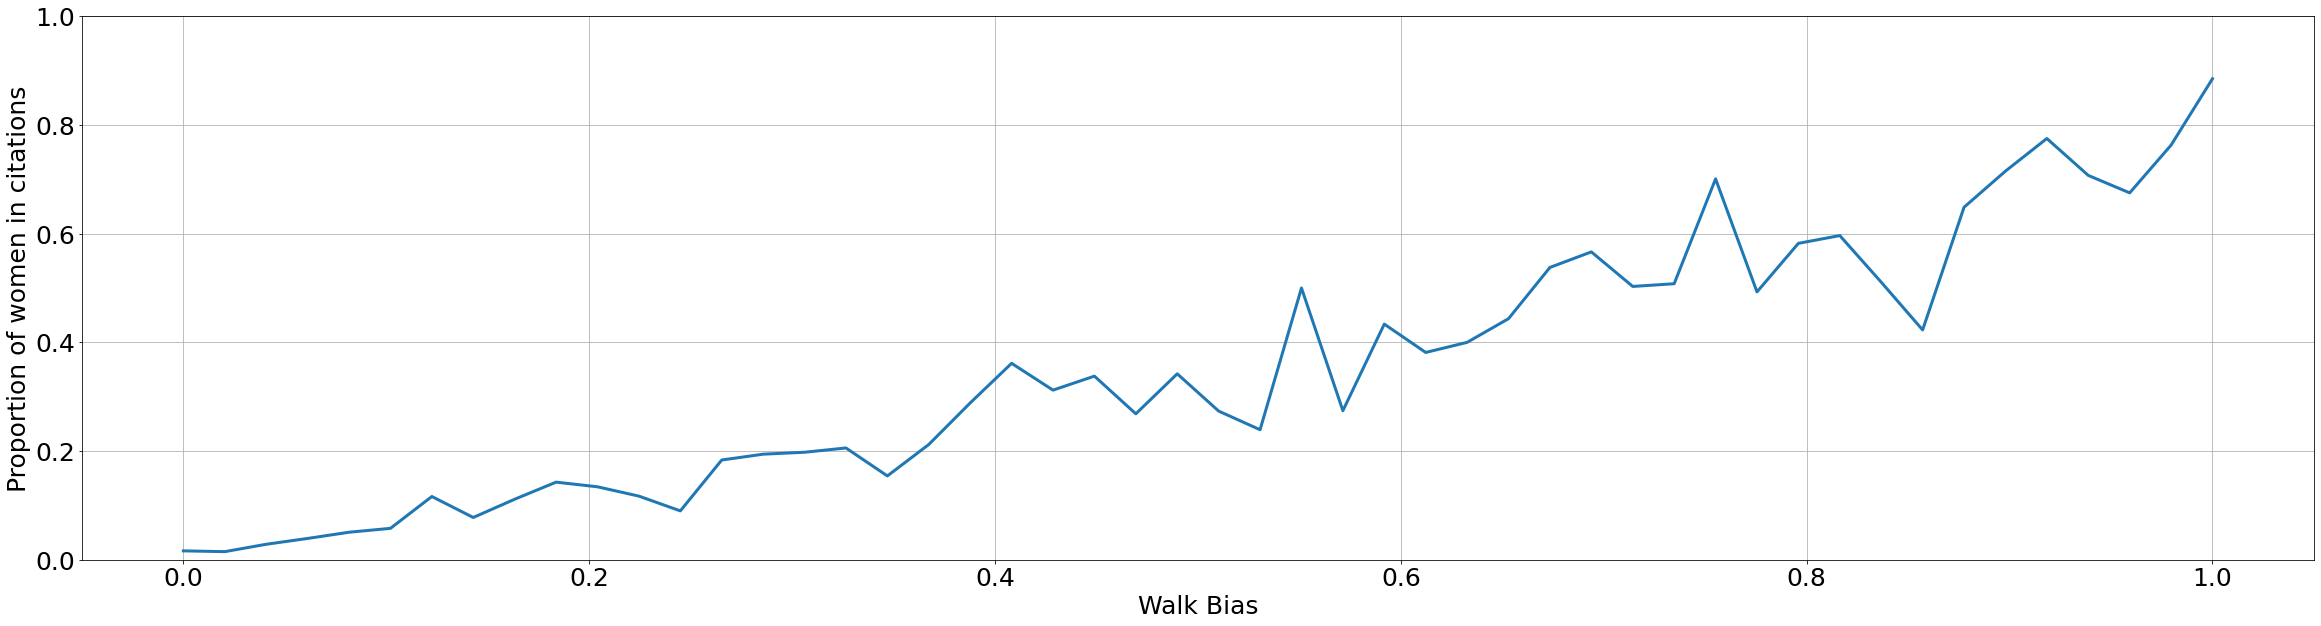

<Figure size 432x288 with 0 Axes>

In [44]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(walk_biases, cites, len(walk_biases), linewidth=3.0)
plt.ylabel('Proportion of women in citations')
plt.xlabel('Walk Bias')
plt.ylim(0,1)
plt.grid(True)
plt.show()
plt.draw()

In [ ]:
# repeat the above test for different reference sizes
nSim = 20
walk_biases = np.linspace(0., 1.,50)
nn = 100
nb = [50, 100, 500, 1000]

def test_cites(b,g,node_2_gender,n,nb,nSim):
    props = np.zeros((nSim,len(nb)))
    a = Author(.5,b,.5,.5,'w')
    a.init_network(g, node_2_gender, n)
    for i,m in enumerate(nb):
        for k in range(nSim):
            bib = a.get_cites(m)
            props[k,i] = sum([val['gender'] == 'woman' for val in bib.values()])/nb
    return np.mean(props,axis=0)

cites = Parallel(n_jobs=1)(
    delayed(test_cites)(b,g,node_2_gender,nn,nb,nSim)
    for b in tqdm(walk_biases) 
)

In [ ]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(walk_biases, cites, len(walk_biases), linewidth=3.0)
plt.ylabel('Proportion of women in citations')
plt.xlabel('Walk Bias')
plt.ylim(0,1)
plt.grid(True)
plt.legend(nb)
plt.show()
plt.draw()

In [41]:
# citation bias with different network biases
nSim = 20
net_biases = np.linspace(0., 1.,50)
nn = 100
nb = 70

def test_cites(b,g,node_2_gender,n,nb,nSim):
    props = np.zeros((nSim,1))
    a = Author(b,.5,.5,.5,'w')
    for k in range(nSim):
        a.init_network(g, node_2_gender, n)
        bib = a.get_cites(nb)
        props[k] = sum([val['gender'] == 'woman' for val in bib.values()])/nb
    return np.mean(props,axis=0)

cites = Parallel(n_jobs=1)(
    delayed(test_cites)(b,g,node_2_gender,nn,nb,nSim)
    for b in tqdm(net_biases) 
)

100%|██████████| 50/50 [14:58<00:00, 17.97s/it]


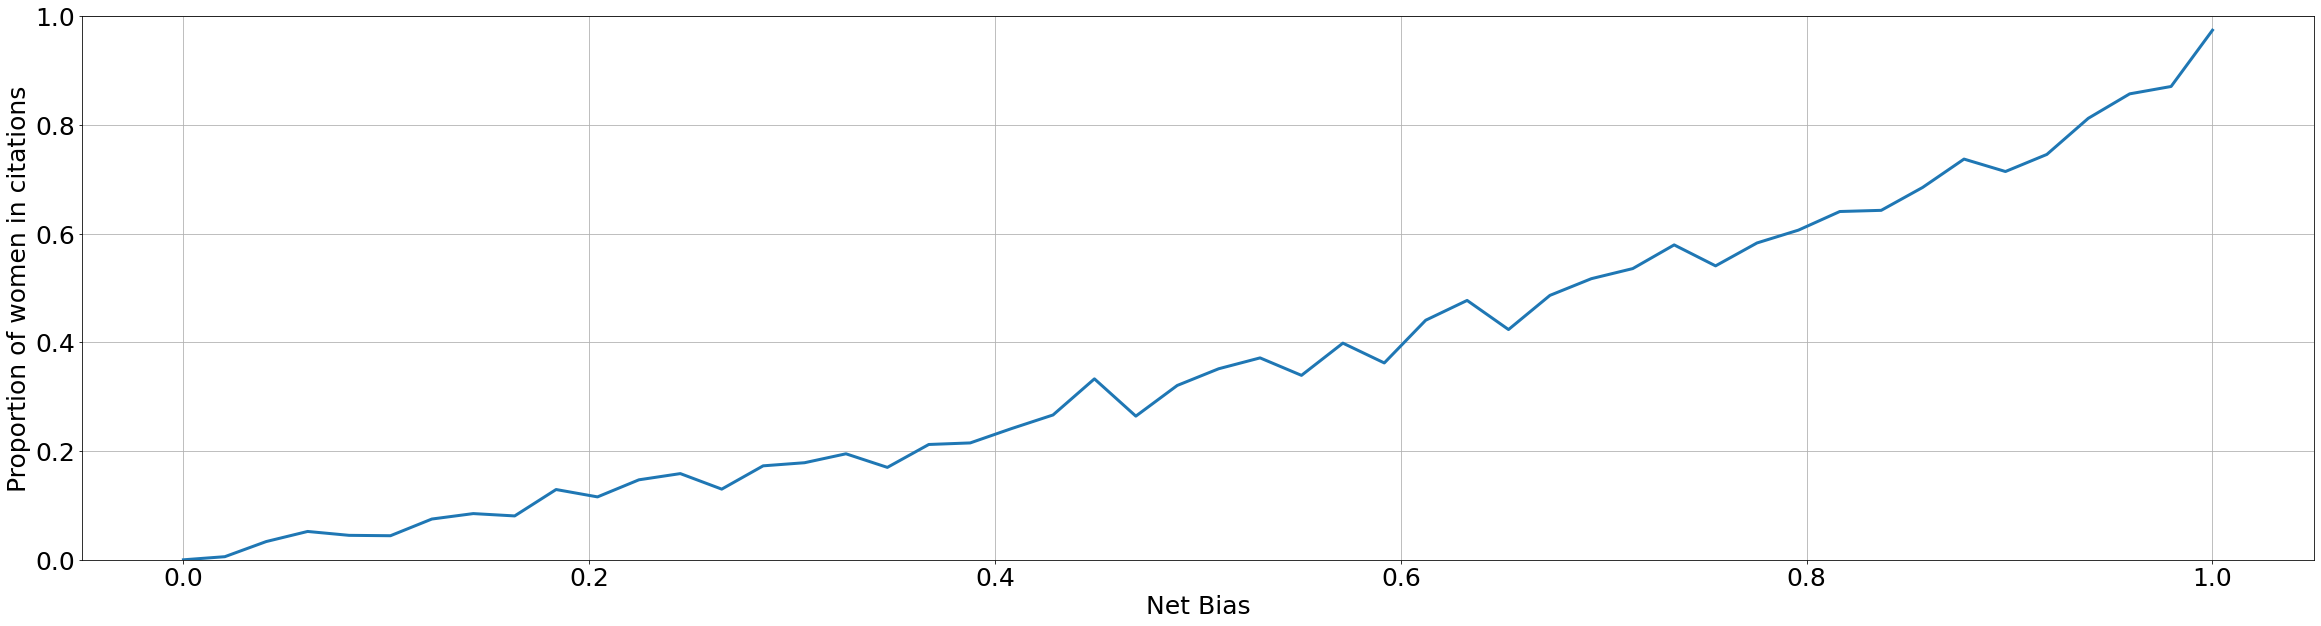

<Figure size 432x288 with 0 Axes>

In [42]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(walk_biases, cites, len(walk_biases), linewidth=3.0)
plt.ylabel('Proportion of women in citations')
plt.xlabel('Net Bias')
plt.ylim(0,1)
plt.grid(True)
plt.show()
plt.draw()

In [52]:
# tiled across net and walk biases
# citation bias with different network biases
nSim = 20
net_biases = np.linspace(0., 1.,50)
walk_biases = np.linspace(0., 1.,50)
nn = 100
nb = 70

def test_cites(b,g,node_2_gender,n,nb,nSim,walk_bias):
    props = np.zeros((len(walk_bias),nSim))
    for i,m in enumerate(walk_bias):
        a = Author(b,m,.5,.5,'w')
        for k in range(nSim):
            a.init_network(g, node_2_gender, n)
            bib = a.get_cites(nb)
            props[i,k] = sum([val['gender'] == 'woman' for val in bib.values()])/nb
    return np.mean(props,axis=1)

cites = Parallel(n_jobs=3)(
    delayed(test_cites)(b,g,node_2_gender,nn,nb,nSim,walk_biases)
    for b in tqdm(net_biases) 
)








  0%|          | 0/50 [00:00<?, ?it/s]






 12%|█▏        | 6/50 [14:31<1:46:33, 145.32s/it]






 18%|█▊        | 9/50 [28:50<2:19:21, 203.95s/it]






 24%|██▍       | 12/50 [43:24<2:29:52, 236.64s/it]






 30%|███       | 15/50 [57:58<2:29:08, 255.66s/it]






 36%|███▌      | 18/50 [1:12:35<2:22:48, 267.75s/it]






 42%|████▏     | 21/50 [1:27:16<2:13:29, 276.18s/it]






 48%|████▊     | 24/50 [1:41:45<2:01:30, 280.39s/it]






  0%|          | 0/50 [2:00:52<?, ?it/s]







 60%|██████    | 30/50 [2:10:33<1:34:48, 284.40s/it]






 66%|██████▌   | 33/50 [2:25:10<1:21:17, 286.89s/it]






 72%|███████▏  | 36/50 [2:39:45<1:07:16, 288.33s/it]






 78%|███████▊  | 39/50 [2:54:12<52:53, 288.48s/it]  






 84%|████████▍ | 42/50 [3:08:45<38:34, 289.31s/it]






 86%|████████▌ | 43/50 [3:08:46<29:31, 253.02s/it]






 90%|█████████ | 45/50 [3:23:12<25:02, 300.52s/it]






100%|██████████| 50/50 [3:37:37<00:00, 261.15s/it]


In [56]:
np.shape(cites)

(50, 50)

Text(0.5, 37.0, 'Walk Bias')

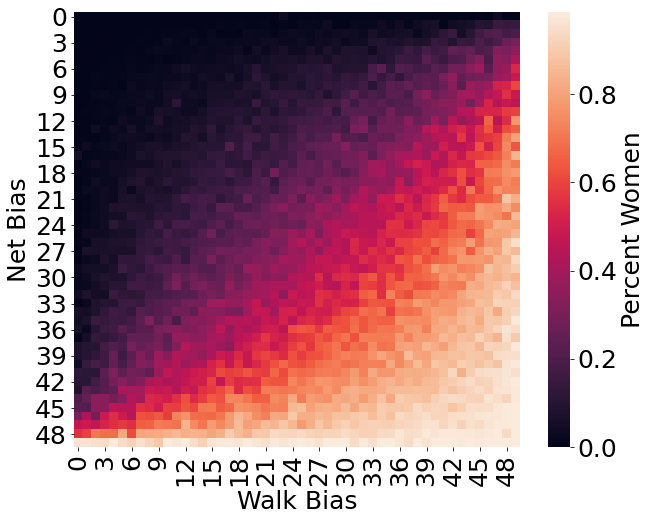

In [73]:
plt.figure(figsize=(10,8))
sns.heatmap(data=cites,cbar_kws={'label': 'Percent Women'})
plt.ylabel('Net Bias')
plt.xlabel('Walk Bias')


### Comparing networks
#### Based on social similarity

In [104]:
# this should run smoothly
a1 = Author(0.5,0.5,0.5,0.5)
a1.init_network(g, node_2_gender, 500)
a2 = Author(0.5,0.5,0.01,0.5)
a2.init_network(g, node_2_gender, 500)
compare_nets(a1,a2)

(False, True)

In [102]:
# this should throw an error
compare_nets(1,a2)

Exception: You must input two Author objects into this function

In [103]:
# this should throw an error
compare_nets(a1,'s')

Exception: You must input two Author objects into this function

### Parameter sweep

In [123]:
# number of successful meetings with different meet biases
nSim = 50
meet_biases = np.linspace(0.,.1,50)
n = 500

def test_meetings(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a1 = Author(0.5,0.5,b,0.5)
    a1.init_network(g, node_2_gender, n)
    a2 = Author(0.5,0.5,0.5,0.5)
    for j in range(nSim):
        a2.init_network(g, node_2_gender, n)
        x = compare_nets(a1,a2)
        props[j,] = x[0]
    return sum(props)/nSim


meets = Parallel(n_jobs=4)(
    delayed(test_meetings)(b,nSim,g,node_2_gender,n)
    for b in tqdm(meet_biases)
) 

100%|██████████| 50/50 [08:58<00:00, 10.77s/it]


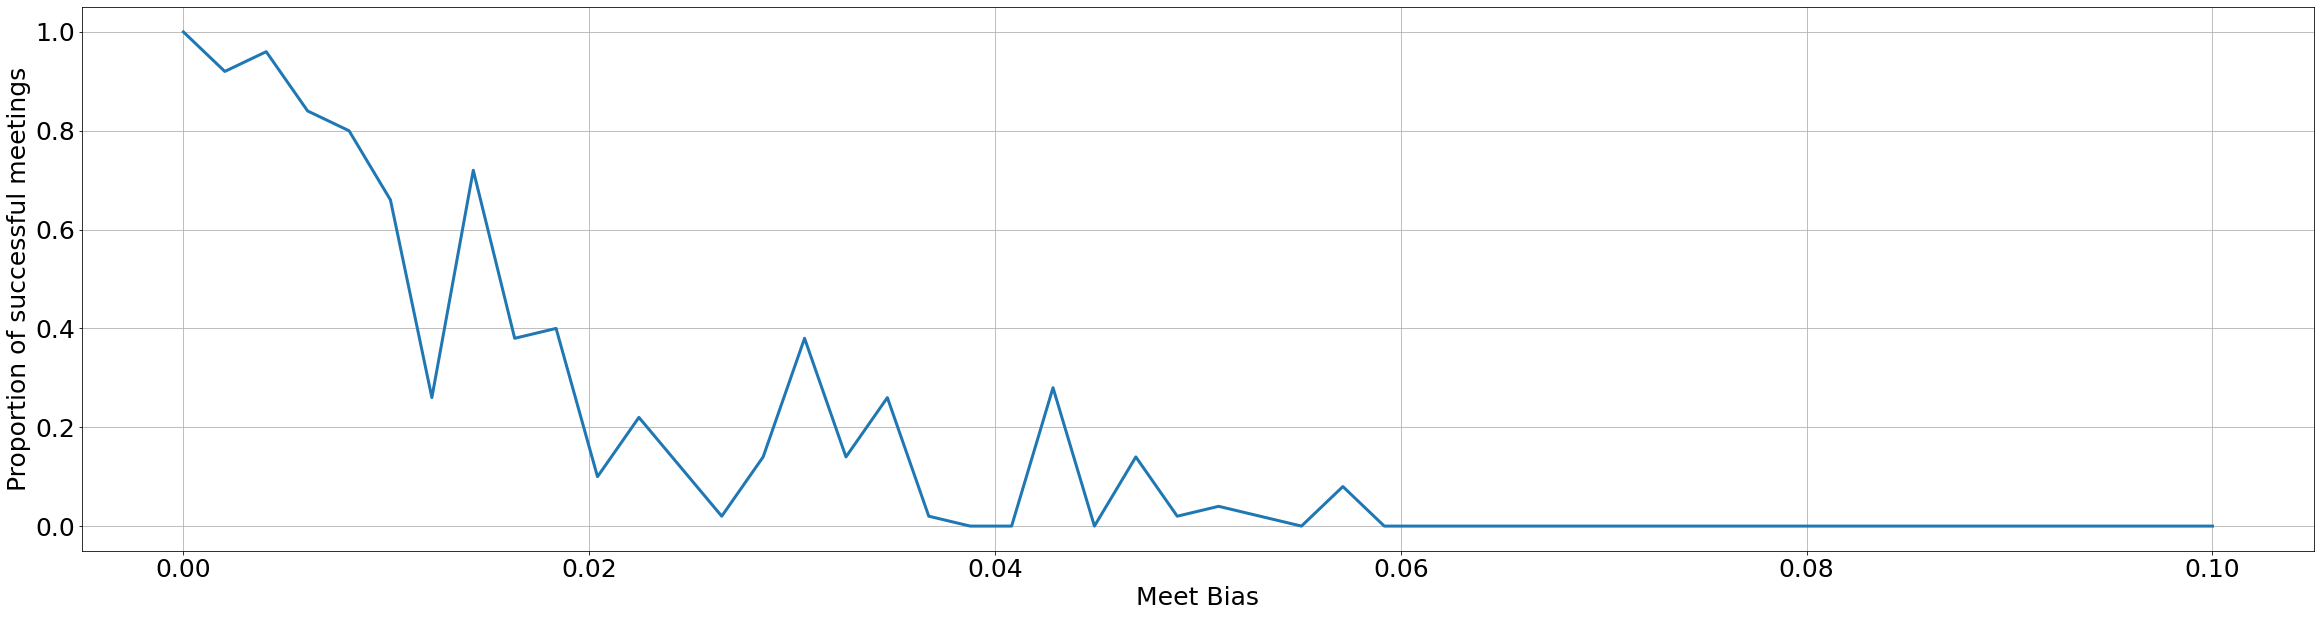

<Figure size 432x288 with 0 Axes>

In [124]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(meet_biases, meets, linewidth=3.0)
plt.ylabel('Proportion of successful meetings')
plt.xlabel('Meet Bias')

plt.grid(True)
plt.show()
plt.draw()

In [128]:
# number of successful meeting with different network sizes
nSim = 50
meet_biases = np.linspace(0.,.1,50)
n = [100, 250, 500, 1000]

def test_meetings(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,len(n)))
    a1 = Author(0.5,0.5,b,0.5)
    a2 = Author(0.5,0.5,0.5,0.5)
    for i,k in enumerate(n):
        a1.init_network(g, node_2_gender, k)
        for j in range(nSim):
            a2.init_network(g, node_2_gender, k)
            x = compare_nets(a1,a2)
            props[j,i] = x[0]
    return np.mean(props, axis=0)


meets = Parallel(n_jobs=4)(
    delayed(test_meetings)(b,nSim,g,node_2_gender,n)
    for b in tqdm(meet_biases)
) 



  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [03:02<15:58, 22.81s/it]

 24%|██▍       | 12/50 [06:02<20:19, 32.09s/it]

 32%|███▏      | 16/50 [09:03<20:56, 36.96s/it]

 40%|████      | 20/50 [12:02<19:49, 39.65s/it]

 48%|████▊     | 24/50 [15:01<17:55, 41.37s/it]

 56%|█████▌    | 28/50 [17:58<15:30, 42.30s/it]

 64%|██████▍   | 32/50 [20:56<12:54, 43.01s/it]

 72%|███████▏  | 36/50 [23:55<10:09, 43.53s/it]

 80%|████████  | 40/50 [26:50<07:15, 43.56s/it]

 88%|████████▊ | 44/50 [29:46<04:22, 43.71s/it]

100%|██████████| 50/50 [32:41<00:00, 39.24s/it]


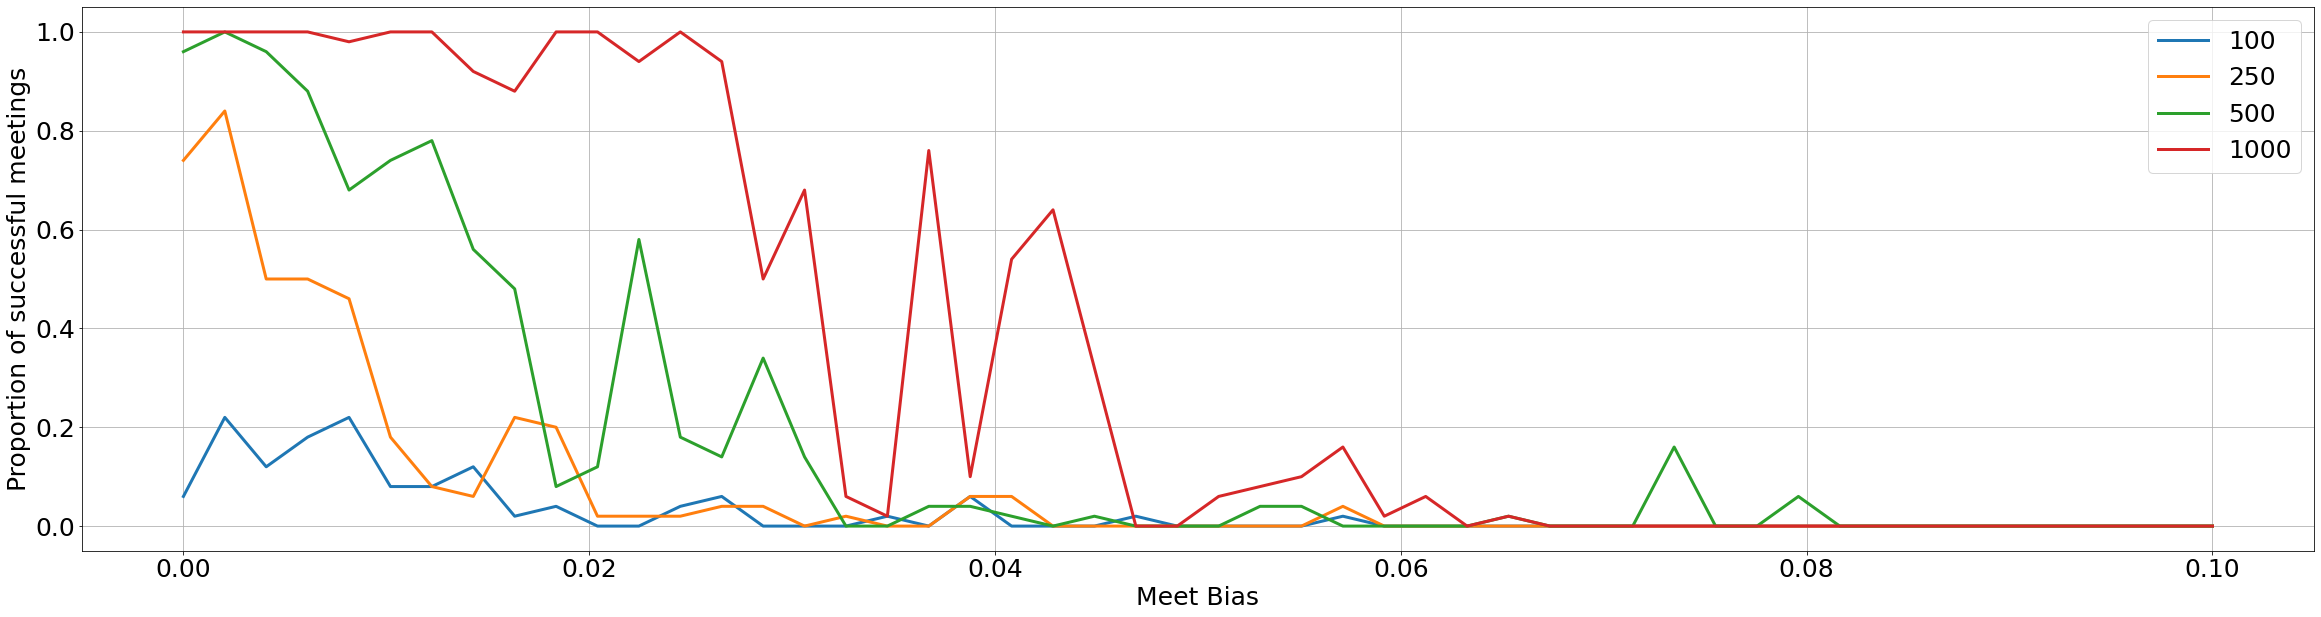

<Figure size 432x288 with 0 Axes>

In [131]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(meet_biases, np.reshape(meets, (len(meet_biases), len(n))), linewidth=3.0)
plt.ylabel('Proportion of successful meetings')
plt.xlabel('Meet Bias')
plt.legend(n)
plt.grid(True)
plt.show()
plt.draw()

In [5]:
# number of successful meetings with net bias
nSim = 50
meet_biases = np.linspace(0.,.1,50)
net_biases = np.linspace(0.,1.,10)
n = 500

def test_meetings(b,nSim,g,node_2_gender,n, nets):
    props = np.zeros((nSim,len(nets)))
    a1 = Author(1.,0.5,b,0.5)
    for i,k in enumerate(nets):
        a2 = Author(k,0.5,0.5,0.5)
        a1.init_network(g, node_2_gender, n)
        for j in range(nSim):
            a2.init_network(g, node_2_gender, n)
            x = compare_nets(a1,a2)
            props[j,i] = x[0]
    return np.mean(props, axis=0)


meets = Parallel(n_jobs=4)(
    delayed(test_meetings)(b,nSim,g,node_2_gender,n,net_biases)
    for b in tqdm(meet_biases)
) 


100%|██████████| 50/50 [2:05:01<00:00, 150.02s/it]


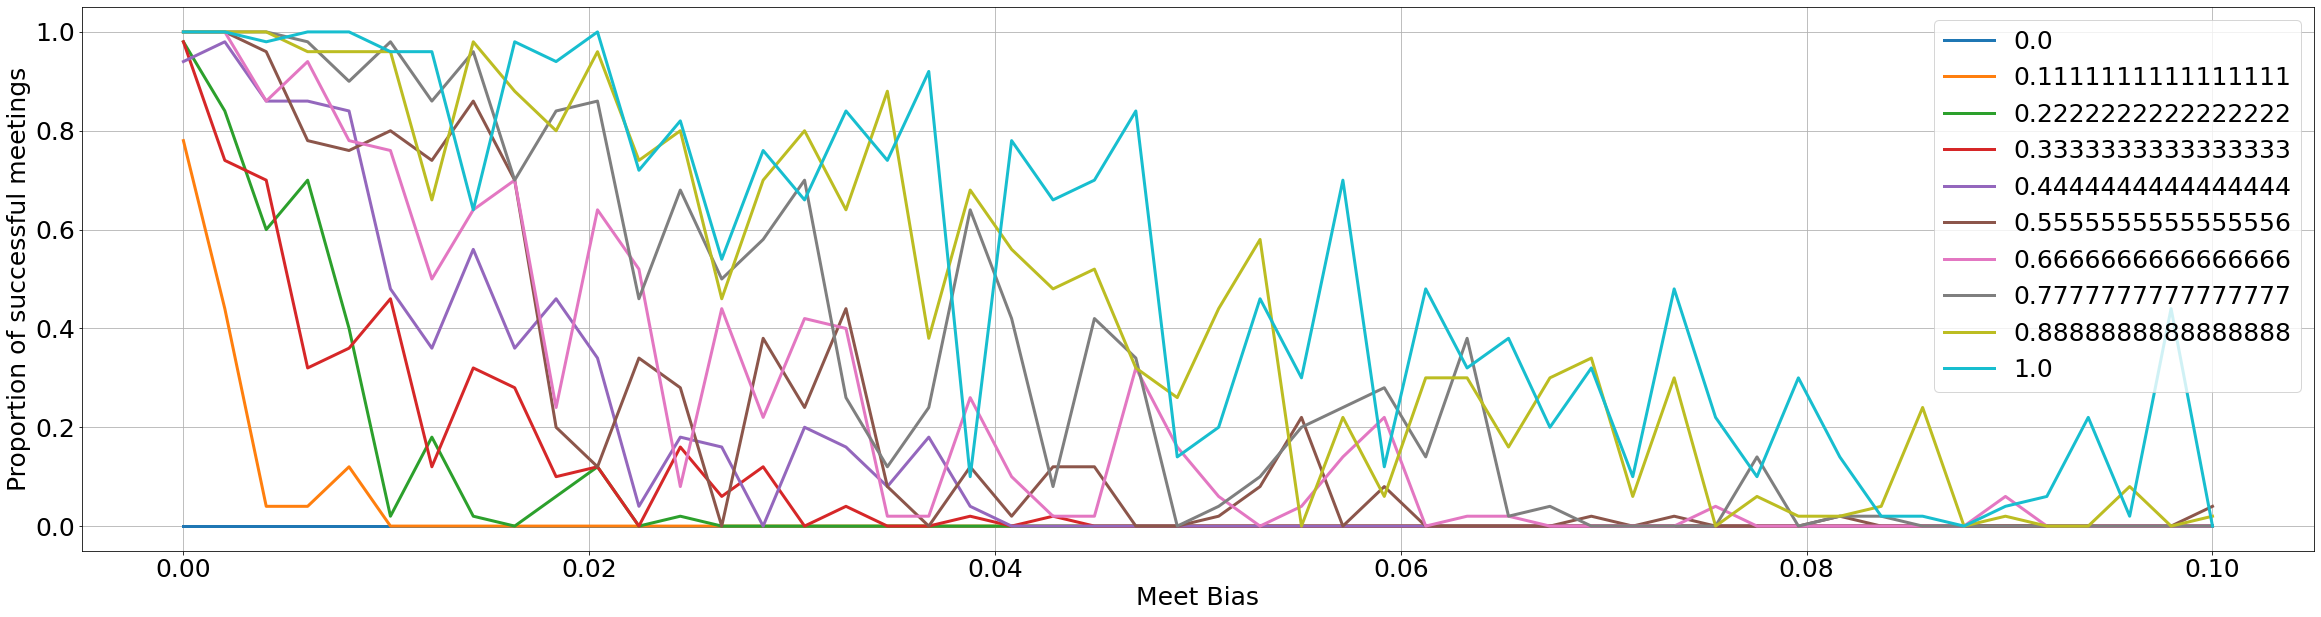

<Figure size 432x288 with 0 Axes>

In [8]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(meet_biases, np.reshape(meets, (len(meet_biases), len(net_biases))), linewidth=3.0)
plt.ylabel('Proportion of successful meetings')
plt.xlabel('Meet Bias')
plt.legend(net_biases)
plt.grid(True)
plt.show()
plt.draw()

### Comparing Networks
#### Based on bias similarity


In [3]:
# this should run smoothly
a1 = Author(0.4,0.6,0.8,0.1)
a1.init_network(g, node_2_gender, 500)
a2 = Author(0.5,0.5,0.01,0.05)
a2.init_network(g, node_2_gender, 500)
compare_nets(a1,a2, method='bi')

(True, False)

In [4]:
# this should throw an error
a1 = Author(0.4,0.6,0.8,0.1)
a1.init_network(g, node_2_gender, 500)
a2 = Author(0.5,0.5,0.01,0.05)
a2.init_network(g, node_2_gender, 500)
compare_nets(a1,a2, method='b')

Exception: You muse enter a valid comparison method

#### Parameter sweep

In [ ]:
# number of successful meetings with different meet biases
nSim = 50
meet_biases = np.linspace(0.,1.,50)
n = 500

def test_meetings(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a1 = Author(0.5,0.5,b,0.5)
    a1.init_network(g, node_2_gender, n)
    a2 = Author(0.5,0.5,0.5,0.5)
    for j in range(nSim):
        a2.init_network(g, node_2_gender, n)
        x = compare_nets(a1,a2,method='bi')
        props[j,] = x[0]
    return sum(props)/nSim


meets = Parallel(n_jobs=4)(
    delayed(test_meetings)(b,nSim,g,node_2_gender,n)
    for b in tqdm(meet_biases)
) 

 72%|███████▏  | 36/50 [06:51<03:00, 12.87s/it]

In [ ]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(meet_biases, meets, linewidth=3.0)
plt.ylabel('Proportion of successful meetings')
plt.xlabel('Meet Bias')

plt.grid(True)
plt.show()
plt.draw()

In [ ]:
# number of successful meetings with net bias
nSim = 50
meet_biases = np.linspace(0.,.1,50)
net_biases = np.linspace(0.,1.,10)
n = 500

def test_meetings(b,nSim,g,node_2_gender,n, nets):
    props = np.zeros((nSim,len(nets)))
    a1 = Author(1.,0.5,b,0.5)
    for i,k in enumerate(nets):
        a2 = Author(k,0.5,0.5,0.5)
        a1.init_network(g, node_2_gender, n)
        for j in range(nSim):
            a2.init_network(g, node_2_gender, n)
            x = compare_nets(a1,a2,method='bi')
            props[j,i] = x[0]
    return np.mean(props, axis=0)


meets = Parallel(n_jobs=4)(
    delayed(test_meetings)(b,nSim,g,node_2_gender,n,net_biases)
    for b in tqdm(meet_biases)
) 

In [ ]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(meet_biases, np.reshape(meets, (len(meet_biases), len(net_biases))), linewidth=3.0)
plt.ylabel('Proportion of successful meetings')
plt.xlabel('Meet Bias')
plt.legend(net_biases)
plt.grid(True)
plt.show()
plt.draw()

### Incorporating walks

In [10]:
# first lets try a walk from the same author - so we should get 0 new nodes, but some new edges
a = Author(0.5,0.5,0.5,0.1)
a.init_network(g, node_2_gender, 500)
bib = a.get_cites(100)
a.network.summary()

'IGRAPH UN-- 500 2477 -- \n+ attr: gender (v), name (v), oid (v)'

<AxesSubplot:>

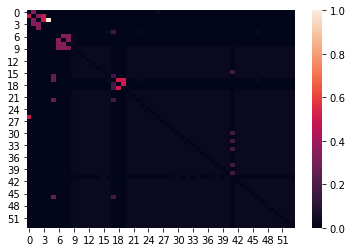

In [11]:
a_hat,a2,b,sg = a.update_network(bib,a.network, debug=True)
sns.heatmap(a2)

<AxesSubplot:>

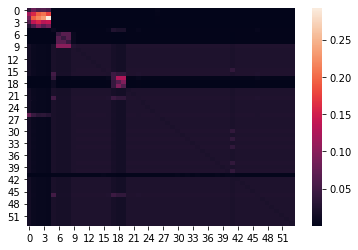

In [12]:
sns.heatmap(a_hat)

<AxesSubplot:>

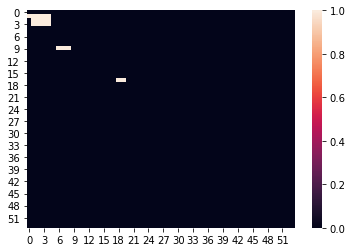

In [13]:
# decision making inertia (Joe Kable) this could be a fifth bias parameter
sns.heatmap(b)

In [14]:
a.network.summary()

'IGRAPH UN-- 500 2483 -- \n+ attr: gender (v), name (v), oid (v)'

In [20]:
# now lets try this with 2 different authors
a1 = Author(0.5,0.5,0.5,0.1)
a1.init_network(g, node_2_gender, 500)
a2 = Author(0.5,0.5,0.5,0.1)
a2.init_network(g, node_2_gender, 500)
bib = a2.get_cites(100)
a1.network.summary()

'IGRAPH UN-- 500 4003 -- \n+ attr: gender (v), name (v), oid (v)'

<AxesSubplot:>

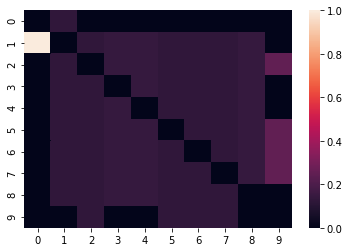

In [21]:
a_hat,a_orig,b,sg = a1.update_network(bib,a2.network, debug=True)
sns.heatmap(a_orig)

<AxesSubplot:>

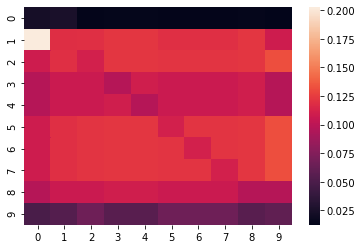

In [22]:
sns.heatmap(a_hat)

<AxesSubplot:>

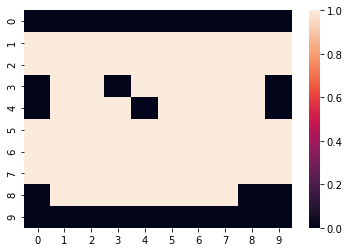

In [23]:
sns.heatmap(b)

In [24]:
a1.network.summary()

'IGRAPH UN-- 510 4035 -- \n+ attr: gender (v), name (v), oid (v)'

#### Parametr sweeps

In [28]:
# test the effect of learn parameter on the size of the network
nSim = 50
learn_biases = np.linspace(0.,1.,50)
n = 500

def test_updates(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a1 = Author(0.5,0.5,.5,b)
    a1.init_network(g, node_2_gender, n)
    a2 = Author(0.5,0.5,0.5,0.5)
    a2.init_network(g, node_2_gender, n)
    for j in range(nSim):
        a1.init_network(g, node_2_gender, n)
        bib = a2.get_cites(100)
        a1.update_network(bib,a2.network)
        props[j,] = len(a1.network.vs())
    return np.mean(props)


props = Parallel(n_jobs=4)(
    delayed(test_updates)(b,nSim,g,node_2_gender,n)
    for b in tqdm(learn_biases)
) 

100%|██████████| 50/50 [09:36<00:00, 11.52s/it]


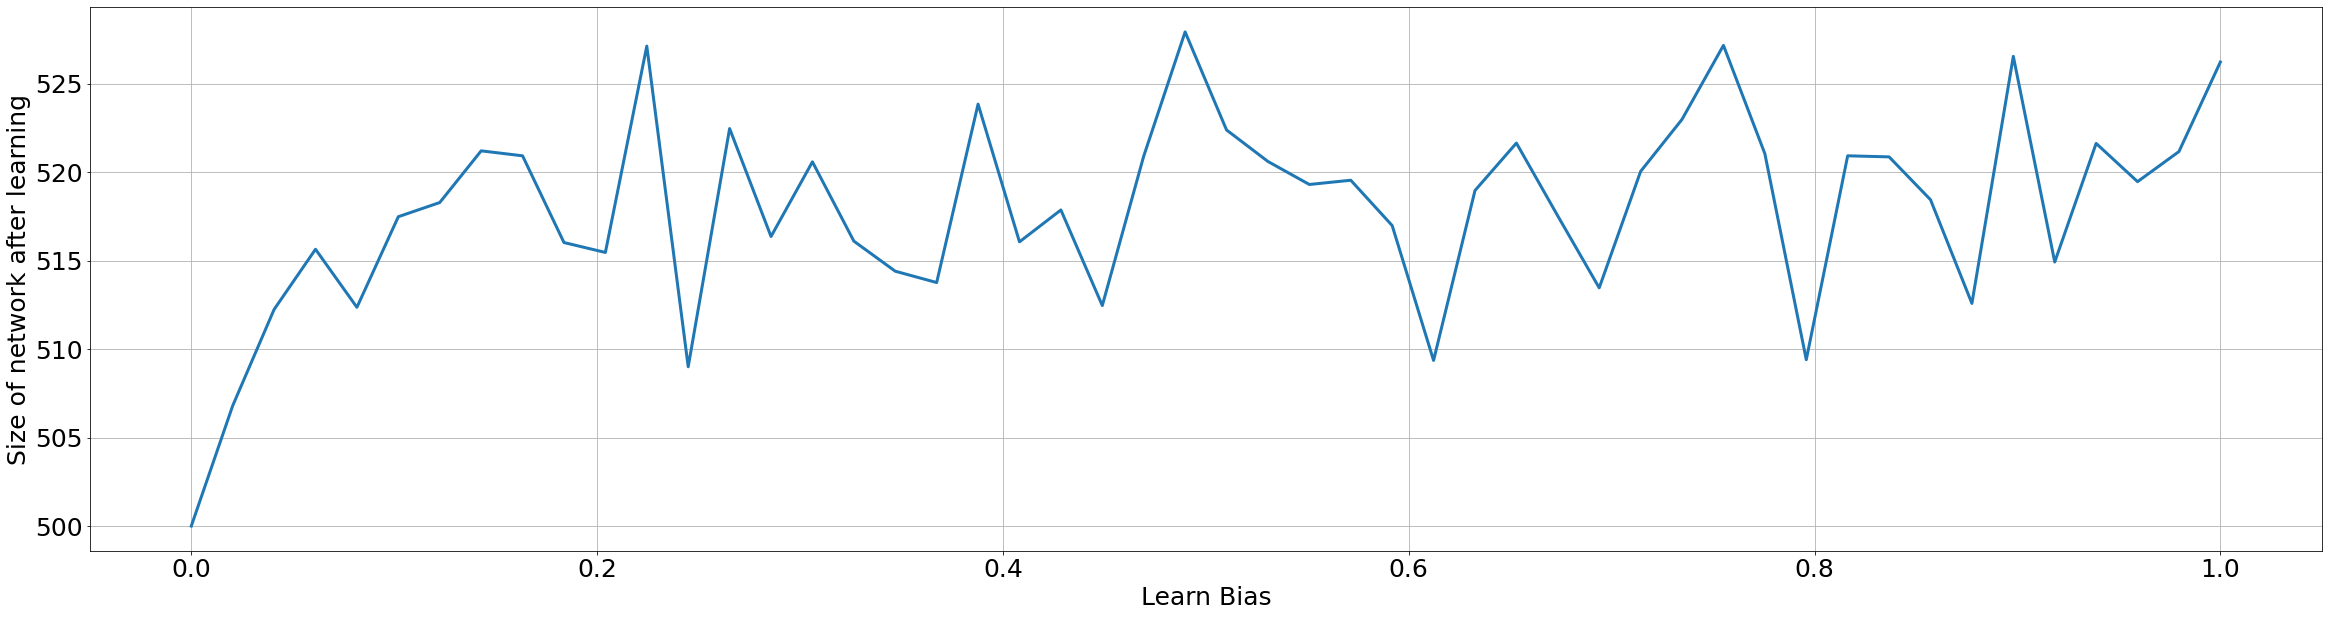

<Figure size 432x288 with 0 Axes>

In [29]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(learn_biases, props, linewidth=3.0)
plt.ylabel('Size of network after learning')
plt.xlabel('Learn Bias')
plt.grid(True)
plt.show()
plt.draw()

In [34]:
# test if gender proportion normalize for people with different walk biases
nSim = 50
net_biases = np.linspace(0.,1.,50)
n = 500

def test_updates(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a1 = Author(0.5,0.5,.5,0.0)
    a1.init_network(g, node_2_gender, n)
    a2 = Author(b,0.5,0.5,0.5)
    a2.init_network(g, node_2_gender, n)
    a1.init_network(g, node_2_gender, n)
    for j in range(nSim):
        bib = a2.get_cites(100)
        a1.init_network(g, node_2_gender, n)
        a1.update_network(bib,a2.network)
        props[j,] = sum([x == 'woman' for x in a1.network.vs()['gender']])/len(a1.network.vs())
    return np.mean(props)


props = Parallel(n_jobs=4)(
    delayed(test_updates)(b,nSim,g,node_2_gender,n)
    for b in tqdm(learn_biases)
)


100%|██████████| 50/50 [03:45<00:00,  4.51s/it]


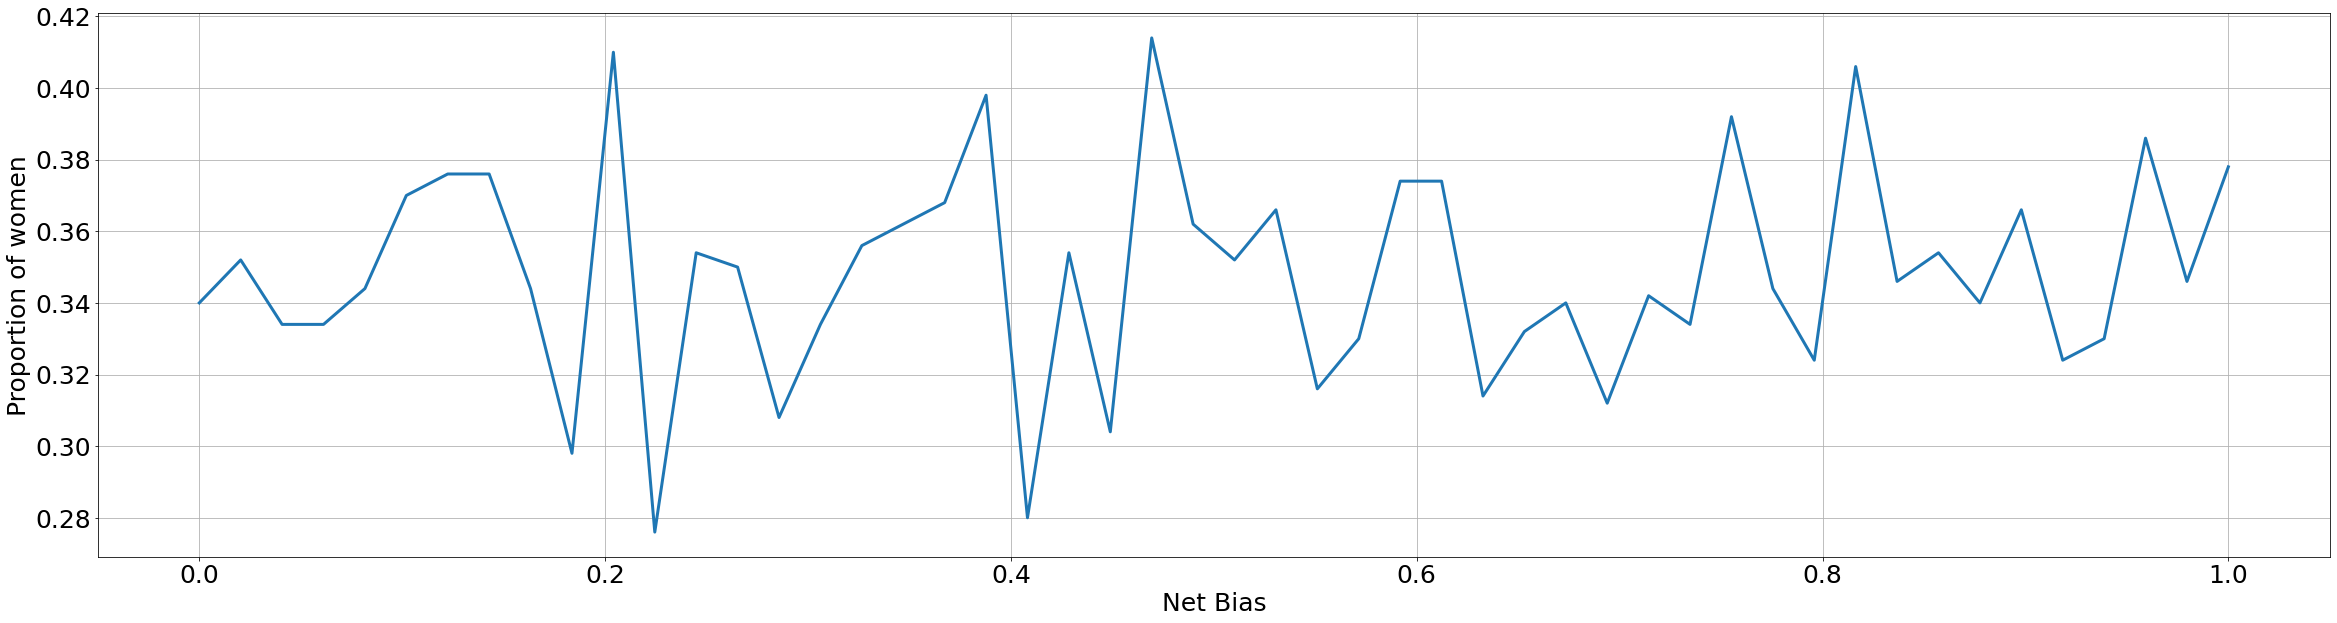

<Figure size 432x288 with 0 Axes>

In [35]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(net_biases, props, linewidth=3.0)
plt.ylabel('Proportion of women')
plt.xlabel('Net Bias')
plt.grid(True)
plt.show()
plt.draw()

In [46]:
# test repeated exposures
nSim = 50
n = 500

props = np.zeros((nSim,))
a1 = Author(0.0,0.5,.5,0.5)
a2 = Author(.8,0.5,0.5,0.5)
a2.init_network(g, node_2_gender, n)
a1.init_network(g, node_2_gender, n)
for i in range(nSim):
    bib = a2.get_cites(100)
    a1.update_network(bib,a2.network)
    props[i,] =  sum([x == 'woman' for x in a1.network.vs()['gender']])/len(a1.network.vs())



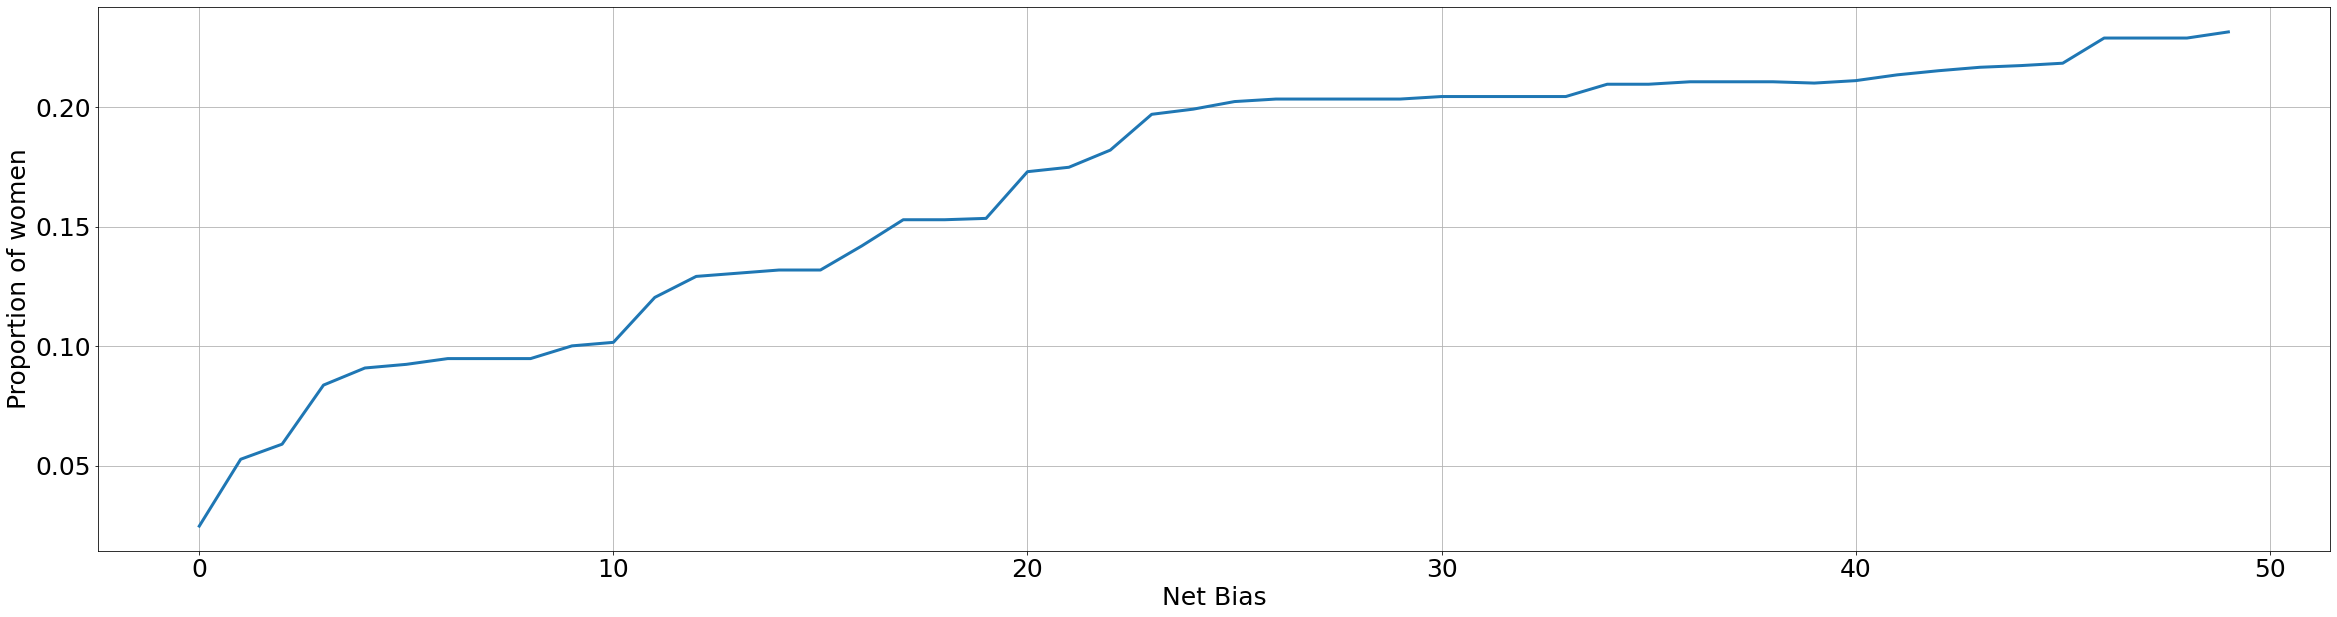

<Figure size 432x288 with 0 Axes>

In [47]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(range(nSim), props, linewidth=3.0)
plt.ylabel('Proportion of women')
plt.xlabel('Net Bias')
plt.grid(True)
plt.show()
plt.draw()